## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time
from keras.utils import img_to_array, load_img

Loading up our image datasets

In [4]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model2.h5' 

# loading up our datasets
train_data_dir = 'dog_types_human_faces/data2'  
validation_data_dir = 'data2'  
test_data_dir = 'data2'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [5]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creation of weights/features with VGG16

In [8]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train2.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 21584 images belonging to 2 classes.


C:\Users\Tom\AppData\Local\Temp\ipykernel_3448\3276551315.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)


Time:  0:01:12.338049


In [9]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [10]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation2.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 12127 images belonging to 2 classes.


C:\Users\Tom\AppData\Local\Temp\ipykernel_3448\1782213983.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(
d:\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time:  0:01:42.753643


In [11]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [8]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test2.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 12127 images belonging to 2 classes.


C:\Users\Tom\AppData\Local\Temp\ipykernel_20088\3235683199.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(
d:\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time:  0:01:49.689629


# Loading training, validation and testing data

In [8]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train2.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 21584 images belonging to 2 classes.


In [9]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation2.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 12127 images belonging to 2 classes.


In [10]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test2.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 12127 images belonging to 2 classes.


# Training of model

In [11]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/7
432/432 [==============================] - 7s 10ms/step - loss: 0.0281 - acc: 0.9893 - val_loss: 0.2945 - val_acc: 0.9260
Epoch 2/7
432/432 [==============================] - 3s 8ms/step - loss: 0.0034 - acc: 0.9987 - val_loss: 0.5655 - val_acc: 0.9016
Epoch 3/7
432/432 [==============================] - 4s 8ms/step - loss: 0.0017 - acc: 0.9994 - val_loss: 0.7260 - val_acc: 0.8860
Epoch 4/7
432/432 [==============================] - 4s 8ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.7552 - val_acc: 0.9014
Epoch 5/7
432/432 [==============================] - 4s 8ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.5337 - val_acc: 0.9297
Epoch 6/7
432/432 [==============================] - 4s 8ms/step - loss: 7.9954e-04 - acc: 0.9997 - val_loss: 0.8886 - val_acc: 0.9010
Epoch 7/7
243/243 [==============================] - 2s 9ms/step - loss: 1.0633 - acc: 0.8993
[INFO] accuracy: 89.93%
[INFO] Loss: 1.0633124113082886
Time:  0:00:35.980056


In [12]:
model.save('animal_class_model2.h5')

In [13]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,514,052
Trainable params: 2,514,052
Non-

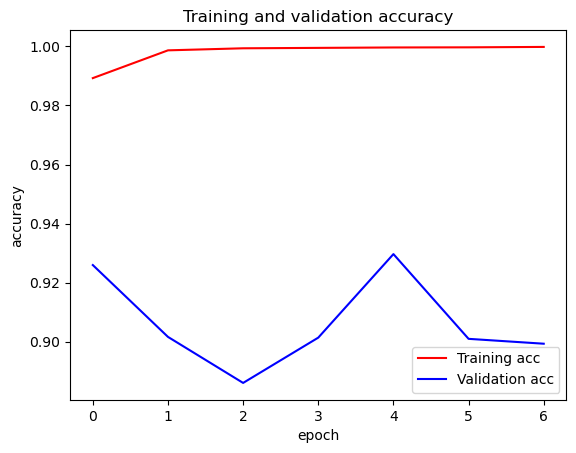

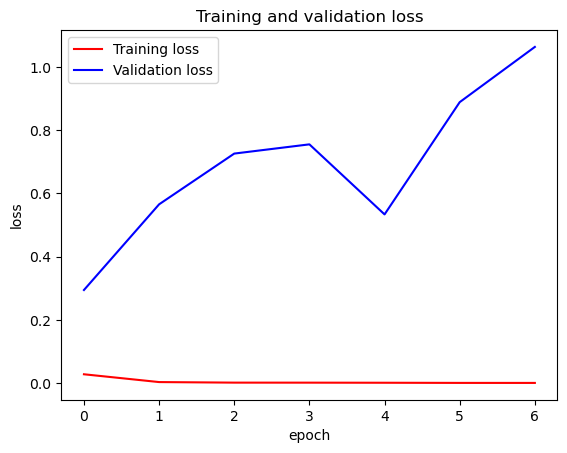

In [14]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [15]:
model.evaluate(test_data, test_labels)

379/379 [==============================] - 1s 3ms/step - loss: 1.0633 - acc: 0.8993


[1.0633116960525513, 0.899315595626831]

## Classification metrics and Confusion Matrix

### Classification Metrics

In [16]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[7.87388921e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.84853446e-01 0.00000000e+00]
   [7.75077701e-01 0.00000000e+00 2.95668840e-01 ... 0.00000000e+00
    2.14120626e-01 0.00000000e+00]
   [7.71993697e-01 0.00000000e+00 1.18852526e-01 ... 0.00000000e+00
    3.67062122e-01 0.00000000e+00]
   ...
   [3.87489676e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.37473398e-01 0.00000000e+00]
   [2.12451786e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.08853078e+00 0.00000000e+00]
   [2.80110300e-01 0.00000000e+00 7.53495693e-02 ... 0.00000000e+00
    1.18252730e+00 0.00000000e+00]]

  [[6.57717884e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    3.27999711e-01 0.00000000e+00]
   [8.71061087e-02 0.00000000e+00 6.41193271e-01 ... 0.00000000e+00
    4.61120963e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 5.79249382e-01 ... 0.00000000e+00
    2.73825318e-01 0.00000000e+00]
   ...
   [1.23623133e-01 0.00000000e+00 4.17493820e-0

In [17]:
animals = ['dogs', 'humans']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

        dogs       0.80      1.00      0.89      4908
      humans       1.00      0.83      0.91      7219

   micro avg       0.90      0.90      0.90     12127
   macro avg       0.90      0.92      0.90     12127
weighted avg       0.92      0.90      0.90     12127
 samples avg       0.90      0.90      0.90     12127



### Confusion Matrix

In [18]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [19]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [20]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


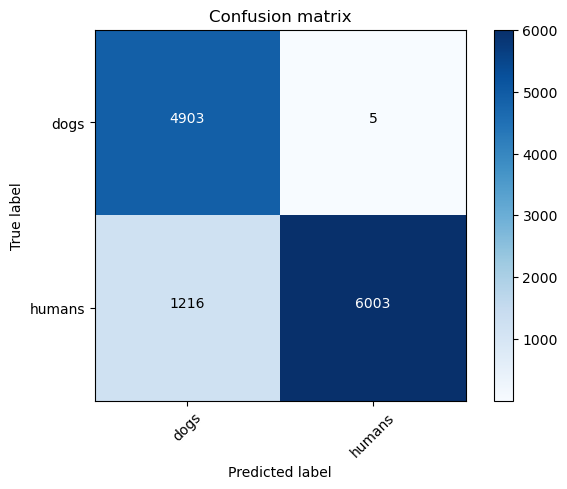

In [21]:
plot_confusion_matrix(confusion_matrix, ['dogs', 'humans'])

Normalized confusion matrix


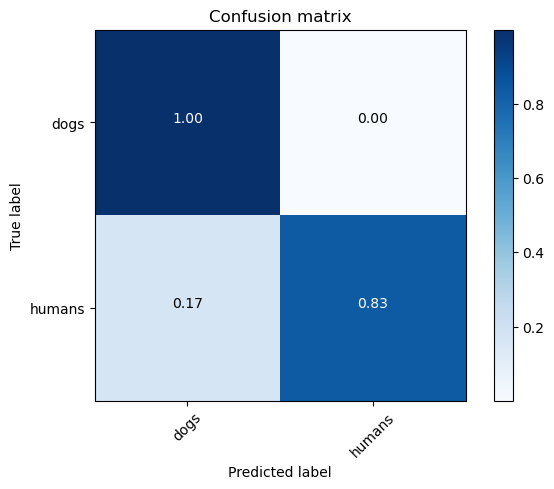

In [22]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['dogs', 'humans'],
                     normalize=True)

## Testing images on model

In [8]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [9]:
def test_single_image(path):
    animals = ['dogs', 'humans']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = preds.argmax(axis=-1)
    class_dictionary = generator_top.class_indices  
    print(class_predicted)
    print(class_dictionary)
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [9]:
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  
model.load_weights(top_model_weights_path)  

In [10]:
model = keras.models.load_model('animal_class_model2.h5')

In [7]:
images = read_image(path)
print(images.shape)
print(images.T)

[INFO] loading and preprocessing image...
(1, 224, 224, 3)
[[[[0.7137255 ]
   [0.627451  ]
   [0.6431373 ]
   ...
   [0.24705882]
   [0.16078432]
   [0.15686275]]

  [[0.5764706 ]
   [0.5254902 ]
   [0.01568628]
   ...
   [0.16862746]
   [0.16470589]
   [0.13333334]]

  [[0.74509805]
   [0.7137255 ]
   [0.5882353 ]
   ...
   [0.37254903]
   [0.10196079]
   [0.16862746]]

  ...

  [[0.654902  ]
   [0.5294118 ]
   [0.5294118 ]
   ...
   [0.28627452]
   [0.21960784]
   [0.20392157]]

  [[0.54509807]
   [0.44705883]
   [0.45490196]
   ...
   [0.2901961 ]
   [0.24705882]
   [0.22352941]]

  [[0.45490196]
   [0.46666667]
   [0.41568628]
   ...
   [0.20784314]
   [0.21568628]
   [0.23137255]]]


 [[[0.85490197]
   [0.7607843 ]
   [0.75686276]
   ...
   [0.35686275]
   [0.26666668]
   [0.2627451 ]]

  [[0.69411767]
   [0.654902  ]
   [0.13333334]
   ...
   [0.2784314 ]
   [0.27450982]
   [0.23921569]]

  [[0.85882354]
   [0.8509804 ]
   [0.7294118 ]
   ...
   [0.48235294]
   [0.21176471]
   [0

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 2,514,256
Trainable params: 2,514,256
Non-

In [24]:
weight = model.get_layer("flatten").get_weights()
print(weight)

[]


In [15]:
from keras import backend as K

get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[5].output])
layer_output = get_1st_layer_output([test_data])
print(layer_output)
model_output = model.predict(test_data)
print(model_output)

[array([[9.99928474e-01, 6.18689228e-05, 1.29662766e-07, 2.03757764e-07,
        9.01008025e-06, 2.35818064e-07],
       [9.99996662e-01, 2.86254021e-06, 3.30783712e-09, 4.68944661e-09,
        4.61950066e-07, 1.63018410e-09],
       [1.44906834e-01, 8.49483252e-01, 2.40399339e-03, 1.95698906e-03,
        9.44273081e-04, 3.04721500e-04],
       ...,
       [4.05499486e-06, 1.48380786e-04, 1.02819136e-07, 1.06931708e-07,
        1.94442528e-05, 9.99827862e-01],
       [3.99107048e-05, 1.29691558e-04, 6.97300711e-05, 1.32374419e-03,
        2.68686228e-02, 9.71568286e-01],
       [3.55375628e-03, 5.92929386e-02, 8.82143807e-03, 9.81936464e-04,
        3.20368230e-01, 6.06981635e-01]], dtype=float32)]
58/58 [==============================] - 0s 2ms/step
[[9.99928474e-01 6.18661434e-05 1.29652875e-07 2.03743213e-07
  9.00967643e-06 2.35800968e-07]
 [9.99996662e-01 2.86228374e-06 3.30745231e-09 4.68888306e-09
  4.61906438e-07 1.62995406e-09]
 [1.44904971e-01 8.49485338e-01 2.40390864e-03 1.

In [12]:
predict_result = np.round(model.predict(test_data),0)
actual_result = test_labels
print(predict_result)
print(actual_result)
# images = read_image(path)
# bt_prediction = vgg16.predict(images)  
# one_predict = model.predict(bt_prediction)
# print(one_predict)

58/58 [==============================] - 0s 4ms/step
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [11]:
path = 'data2/1 (44).png'

In [12]:
test_single_image(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 61ms/step
ID: 0, Label: dogs 0.02%
ID: 1, Label: humans 99.98%
Final Decision:
.
..
...


NameError: name 'generator_top' is not defined

In [13]:
def noisy(noise_typ, image, val=1000):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = val # 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.1 # 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        # gauss = np.random.randn(row,col,ch)
        gauss = np.random.normal(0, 1, row * col * ch)
        gauss = gauss.reshape(row,col,ch)
        noisy = image + image * gauss
        return noisy

In [14]:
def read_image_noise(image_arr):
    image_arr = image_arr.astype(np.float32)
    image = np.expand_dims(image_arr, axis=0)
    image /= 255.  
    return image

In [15]:
def SNR(noisy_image, image, var_noise):
    mean_image = np.mean(image)
    # if not var_noise:
    noise = noisy_image - image
    mean_noise = np.mean(noise)
    noise_diff = noise - mean_noise
    var_noise = np.sum(np.mean(noise_diff**2)) ## variance of noise
    r2 = image.reshape(image.shape[0],-1)
    p2 = noisy_image.reshape(noisy_image.shape[0],-1)
    n_mse = np.mean(np.sum(np.square(r2 - p2), axis=1)/(np.sum(np.square(r2), axis=1)))
    mse = np.mean(np.sum(np.square(r2 - p2), axis=1))

    if var_noise == 0:
          snr = 100 ## clean image
    else:
          snr = (np.log10(mean_image/var_noise**0.5))*20 ## SNR of the image
    # print(var_noise)
    print(n_mse)
    # print(mse)
    return snr

In [16]:
from keras.utils import array_to_img
import matplotlib.pyplot as plt
import cv2
# from PIL import ImageFilter

In [17]:
denoise_autoencoder = keras.models.load_model('denoiser_ae.h5')

In [18]:
# import required module
from playsound import playsound
from datetime import datetime
# for playing note.mp3 file

def predicting(img_arr, img_arr_orig, class_predicted, img_var=None):
    animals = ['dogs', 'humans']
    img = array_to_img(img_arr)
    images = read_image_noise(img_arr)
    img_snr = SNR(img_arr, img_arr_orig, img_var)
    # time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        if idx == class_predicted:
            acc = x
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2)))
    plt.imshow(img)
    plt.show()
    return acc, img_snr

def noisying(img):
    animals = ['dogs', 'humans']
    img_arr_orig = img_to_array(img)
    images = read_image_noise(img_arr_orig)
    img_snr = 100
    # time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    class_predicted = preds.argmax(axis=-1)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        if animal == 'dogs':
            dog = x
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2)))
    plt.imshow(img)
    plt.show()
    accs = []
    snrs = []
    for x in range(10,15):
        img_var = 2**x
        # img_arr = noisy("gauss", img_arr_orig, img_var)
        img_arr = img_arr_orig + np.random.normal(loc = 0.0, scale = img_var**.5, size=img_arr_orig.shape)
        print("--------------------")
        result = predicting(img_arr, img_arr_orig, class_predicted, img_var)
        img_n = array_to_img(img_arr)
        img_narr = np.array(img_n)
        # img_filt = cv2.bilateralFilter(img_narr, 5, 50, 50)
        # img_filt_arr = img_to_array(img_filt)
        # predicting(img_filt_arr, img_arr_orig, class_predicted)
        # img_fden = cv2.fastNlMeansDenoisingColored(img_narr,None,10,10,7,21)
        # img_fden_arr = img_to_array(img_fden)
        # predicting(img_fden_arr, img_arr_orig, class_predicted)
        img_filt = ((denoise_autoencoder.predict(read_image_noise(img_narr)).reshape(224, 224, 3)) * 255).astype('uint8')
        img_filt_arr = img_to_array(img_filt)
        predicting(img_filt_arr, img_arr_orig, class_predicted)
        # img_filt = cv2.GaussianBlur(img_narr, (3,3), 0)
        # img_filt_arr = img_to_array(img_filt)
        # predicting(img_filt_arr, img_arr_orig, class_predicted)
        # img_filt = img_n.filter(ImageFilter.ModeFilter)
        # img_filt_arr = img_to_array(img_filt)
        # predicting(img_filt_arr, img_arr_orig, class_predicted)
        accs.append(result[0])
        snrs.append(result[1])
    print(accs)
    print(snrs)
    plt.plot(snrs, accs)
    plt.xlabel('SNR(dB)')
    plt.ylabel('Accuracy')
    plt.title('Image with Gaussian Noise')
    plt.yscale('log')
    plt.show()
    return dog

def test_single_image_noise(path):
    img = load_img(path, target_size=(224, 224))
    acc = noisying(img)
    print(acc)

1/1 [==============================] - 0s 16ms/step
ID: 0, Label: dogs 0.02%
ID: 1, Label: humans 99.98%


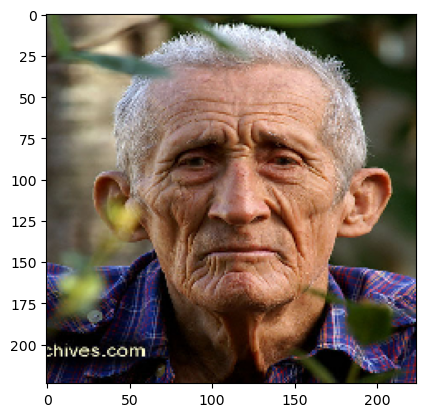

--------------------
0.1250963977208564
1/1 [==============================] - 0s 17ms/step
ID: 0, Label: dogs 0.0%
ID: 1, Label: humans 100.0%


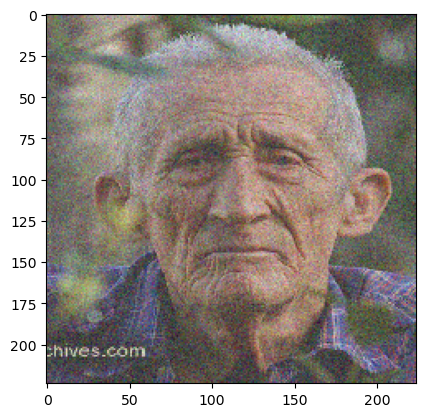

1/1 [==============================] - 0s 318ms/step
0.26425594
1/1 [==============================] - 0s 17ms/step
ID: 0, Label: dogs 0.04%
ID: 1, Label: humans 99.96%


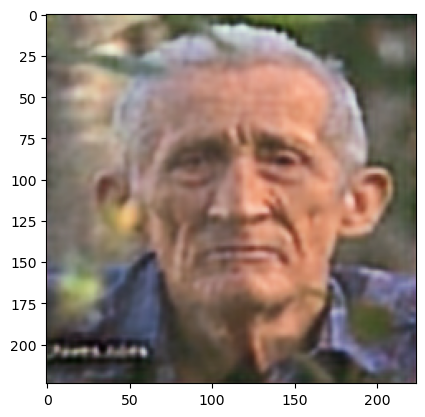

--------------------
0.24850283535031648
1/1 [==============================] - 0s 16ms/step
ID: 0, Label: dogs 2.18%
ID: 1, Label: humans 97.82%


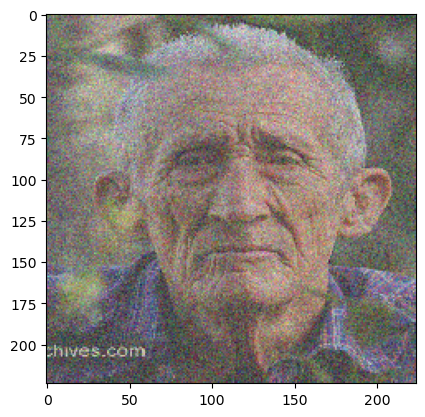

1/1 [==============================] - 0s 18ms/step
0.338552
1/1 [==============================] - 0s 16ms/step
ID: 0, Label: dogs 42.25%
ID: 1, Label: humans 57.75%


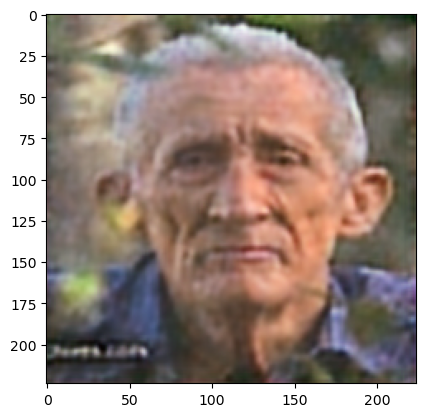

--------------------
0.4956594689975221
1/1 [==============================] - 0s 15ms/step
ID: 0, Label: dogs 99.94%
ID: 1, Label: humans 0.06%


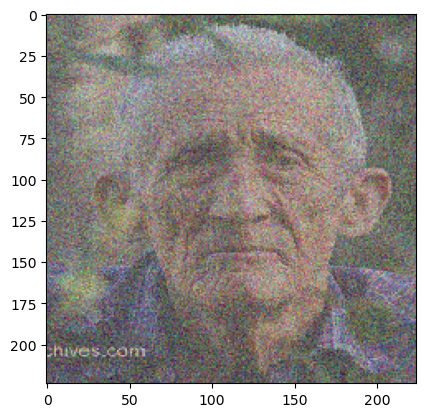

1/1 [==============================] - 0s 17ms/step
0.3985247
1/1 [==============================] - 0s 16ms/step
ID: 0, Label: dogs 100.0%
ID: 1, Label: humans 0.0%


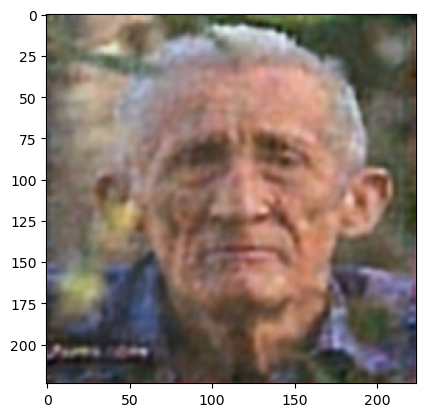

--------------------
0.9891911592297085
1/1 [==============================] - 0s 17ms/step
ID: 0, Label: dogs 100.0%
ID: 1, Label: humans 0.0%


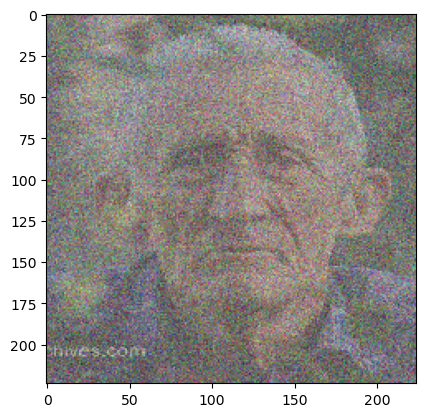

1/1 [==============================] - 0s 19ms/step
0.50762933
1/1 [==============================] - 0s 16ms/step
ID: 0, Label: dogs 100.0%
ID: 1, Label: humans 0.0%


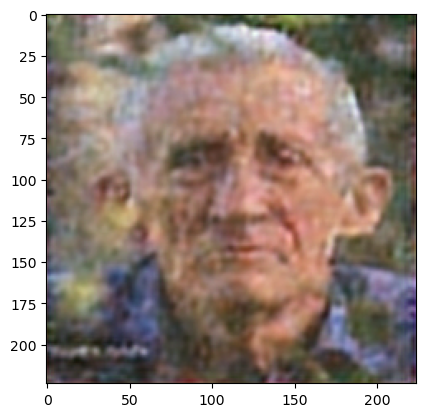

--------------------
1.9773683151571662
1/1 [==============================] - 0s 16ms/step
ID: 0, Label: dogs 100.0%
ID: 1, Label: humans 0.0%


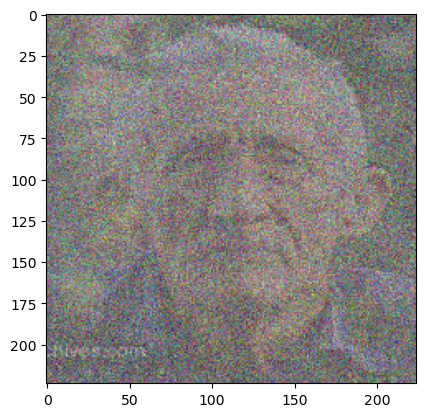

1/1 [==============================] - 0s 24ms/step
0.52679276
1/1 [==============================] - 0s 15ms/step
ID: 0, Label: dogs 100.0%
ID: 1, Label: humans 0.0%


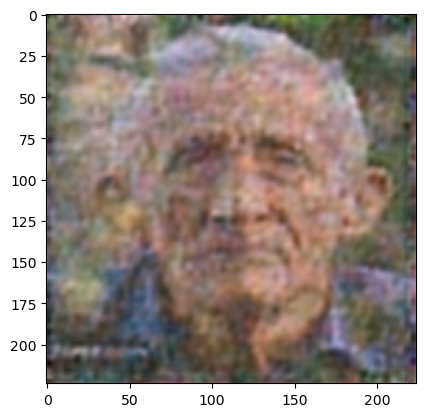

[0.99996424, 0.97823334, 0.00055542035, 1.5649192e-11, 4.4824073e-15]
[9.490903344237513, 6.464309374157191, 3.4719149429360656, 0.47067448241338405, -2.542525205773031]


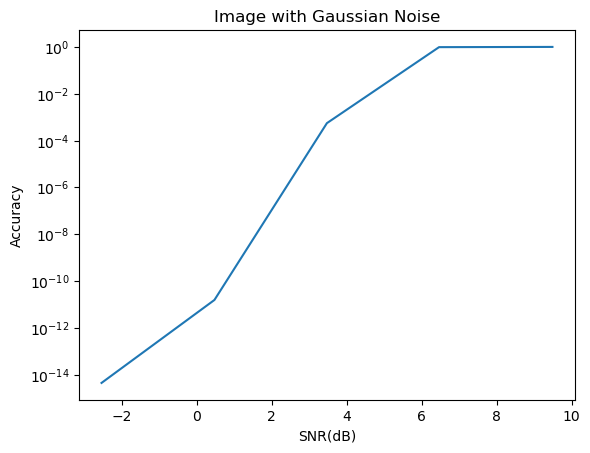

0.00018633038


In [19]:
test_single_image_noise(path)